In [1]:
import os
import socket
from tqdm import tqdm
from copy import deepcopy as copy
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import hist
from scipy.stats import gaussian_kde
from scipy.ndimage import generic_filter, gaussian_filter
import pandas as pd
import seaborn as sns


sns.set_theme(context="poster", style="ticks",
              palette="Set2", color_codes=True)


from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

from pyFIT3D.common.constants import __c__
from pyFIT3D.common.tools import get_wave_from_header


HOSTNAME = socket.gethostname()

In [2]:
MANGA_SCALE = 0.5 # arcsec/pix
MANGA_PSF = 2.5/2.355 # arcsec
MANGA_ALPHA = 1.06

if HOSTNAME == "chiripa":
    PRODUCTS_PATH = "../../_fitting-data/IC342/preprocessed"
    OBS_PATH = "../../_fitting-data/IC342/cubes"
elif HOSTNAME == "orion":
    PRODUCTS_PATH = "/media/mejia/Elements/_fitting-data/IC342/preprocessed"
    OBS_PATH = "/media/mejia/Elements/_fitting-data/IC342/cubes"
else:
    raise IOError(f"unknown host '{HOSTNAME}'")
# OUTPUT_PATH = "_data/ic342/out"

CUBE_FMT = "{}.cube.fits.gz"

POINTING = "manga-10146-12704"

WAVE_NORM = 5450, 5550

In [4]:

cube = fits.open(os.path.join(OBS_PATH, CUBE_FMT.format(POINTING)))
obs_cube = cube[0].data
err_cube = cube[1].data
err_cube[err_cube==1] = np.nanmean(err_cube[(err_cube>0)&(err_cube!=1)])
# err_cube = 1/np.sqrt(cube[0].data)
obs_wl = get_wave_from_header(cube[0].header, wave_axis=3)

wl_mask = (WAVE_NORM[0] <= obs_wl) & (obs_wl <= WAVE_NORM[1])

In [5]:
from scipy.optimize import least_squares


def n_spaxel(snr_goal, snr_ij, alpha):
    guess = snr_goal / snr_ij
    delta = max(np.sqrt(guess), 1)
    current = snr_goal / snr_ij * (1 + alpha * 2*np.log10(guess))
    while np.abs(current - guess) > delta:
        guess = current
        current = snr_goal / snr_ij * (1 + alpha * 2*np.log10(guess))
    return current

# def n_spaxel(snr_goal, snr_ij, alpha):
#     def func(x):
#         return (snr_goal/snr_ij) * (1 + alpha * np.log10(x)) - np.sqrt(x)
    
#     x = np.linspace(1, 70, 1000)
#     plt.plot(x, func(x))

#     res = least_squares(func, x0=1, bounds=(1, 70)).x[0]

#     print((snr_goal/snr_ij)**2, res)

#     return res

# fijar la SNR_goal
# calcular mapa de SNR
# fijar un radio maximo (dependiendo de la escala de la galaxia, FWHM, etc)
# fijar una SNR minima que asegure la estadistica poissoniana
# para cada spaxel (no enmascarado):
#   si >SNR_min, continuar, sino regresar el spaxel original
#   calular el radio dentro del cual se alcanza la SNR_goal
#   si <r_max, continuar, sino truncar a r_max
#   integrar el cubo dentro de dicho radio
#   propagar el error dentro de dicho radio
#   calular la SNR y comparar con la SNR_goal
def snr_remap(obs_cube, err_cube, wl, psf_pix=MANGA_PSF/MANGA_SCALE, r_max=None, snr_window=WAVE_NORM, snr_min=3, snr_goal=40, alpha=MANGA_ALPHA):
    bad_mask = (obs_cube<=0).all(axis=0) | (err_cube<=0).all(axis=0) | np.isnan(obs_cube).all(axis=0) | np.isnan(err_cube).all(axis=0)
    snr_mask = (snr_window[0] <= wl) & (wl <= snr_window[1])
    ny, nx = bad_mask.shape
    if r_max is None:
        r_max = psf_pix
    
    pixels_x, pixels_y = np.arange(nx), np.arange(ny)
    I, J = np.meshgrid(pixels_x, pixels_y)

    obs_cube_ = copy(obs_cube)
    obs_cube_[:, bad_mask] = 0
    err_cube_ = gaussian_filter(copy(err_cube), sigma=(0, psf_pix, psf_pix))
    err_cube_[:, bad_mask] = 0

    org_snr_map = np.nanmedian(np.divide(obs_cube_[snr_mask], err_cube_[snr_mask], where=err_cube_[snr_mask]!=0, out=err_cube_[snr_mask]), axis=0)

    obs_cube_rm, err_cube_rm = copy(obs_cube_), copy(err_cube_)
    pix_map = np.ones_like(bad_mask, dtype=int)
    new_snr_map = copy(org_snr_map)
    for j, i in tqdm(it.product(range(ny), range(nx)), total=nx*ny, desc="remapping SNR", unit="spaxel", ascii=True):
        if bad_mask[j, i]: continue
        if org_snr_map[j,i] >= snr_goal: continue
        if org_snr_map[j,i] < snr_min: continue
        r_guess = (snr_goal / org_snr_map[j,i]) / np.sqrt(np.pi)
        if r_guess > r_max:
            r_voxel = r_max
            n_pixel = np.pi * r_voxel*r_voxel
        else:
            n_pixel = n_spaxel(snr_goal, org_snr_map[j,i], alpha)
            r_voxel = np.ceil(np.sqrt(n_pixel / np.pi)).astype(int)

        window = ((I-i)**2 + (J-j)**2 <= r_voxel*r_voxel).astype(int)

        covar = 1 + alpha * np.log10(n_pixel)
        
        obs_cube_rm[:, j, i] = (obs_cube_ * window[None]).sum(axis=(1,2))/n_pixel
        err_cube_rm[:, j, i] = np.sqrt((err_cube_**2 * window[None]).sum(axis=(1,2))/n_pixel)*covar

        new_snr_map[j, i] = np.nanmedian(obs_cube_rm[snr_mask, j, i]/err_cube_rm[snr_mask, j, i], axis=0)
        pix_map[j, i] = n_pixel
        
    return obs_cube_rm, err_cube_rm, new_snr_map, pix_map

In [6]:
obs_cube_new, err_cube_new, snr_map, n_pix_map = snr_remap(
    obs_cube=obs_cube,
    err_cube=err_cube,
    wl=obs_wl,
    snr_goal=40,
    snr_min=1
    )

remapping SNR: 100%|##########| 5184/5184 [10:05<00:00,  8.57spaxel/s] 


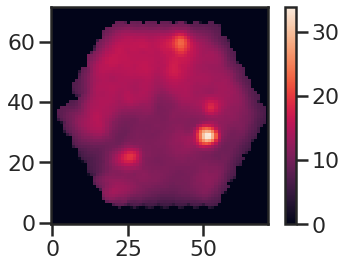

In [7]:
plt.imshow(np.nanmedian(obs_cube/gaussian_filter(err_cube, sigma=(0, MANGA_PSF/MANGA_SCALE, MANGA_PSF/MANGA_SCALE)), axis=0), origin="lower")
plt.colorbar()

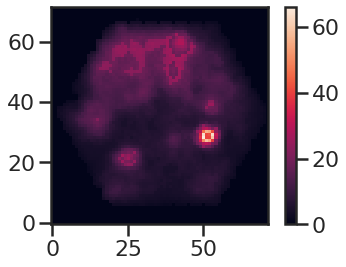

In [8]:
plt.imshow(snr_map, origin="lower")
plt.colorbar()

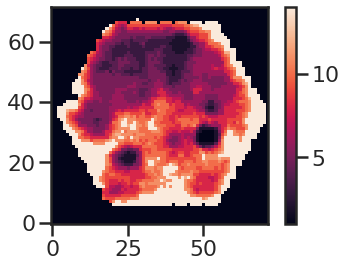

In [9]:
plt.imshow(n_pix_map, origin="lower")
plt.colorbar()

In [12]:
cube_new = copy(cube)

cube_new[0].data = obs_cube_new
cube_new[1].data = err_cube_new

cube_new.writeto(f"{POINTING}.snr-remapped.fits.gz")